# 3D volumetric rendering with NeRF

## Introduction
| ![2d-train](https://i.imgur.com/DQM92vN.png) |
| :---: |
| **Figure 1**: A network being given coordinates of an image
as input and asked to expect the color at the coordinates. |

The network would hypothetically (overfit on) the
image. This means that our network would have encoded the entire image
in its weights. We could query the network with each position,
and it would eventually reconstruct the entire image.

| ![2d-test](https://i.imgur.com/6Qz5Hp1.png) |
| :---: |
| **Figure 2**: The trained network rebuild the image from scratch. |

 The network learns to model the volumetric scene,
thus generating novel views (images) of the 3D scene that the model
was not shown at training time.

## Setup

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

# Setting seed
import tensorflow as tf
tf.random.set_seed(42)

import keras
from keras import layers

import os
import glob
import imageio.v2 as imageio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initializing global variables.
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 5
NUM_SAMPLES = 32
POS_ENCODE_DIMS = 16
EPOCHS = 20

## Downloading and loading the data

The `npz` data file contains images, camera poses, and a focal length.
The images are taken from multiple camera angles as shown in
**Figure 3**.

| ![camera-angles](https://i.imgur.com/FLsi2is.png) |
| :---: |
| **Figure 3**: Multiple camera angles <br>|

Consider the following equation:

<img src="https://i.imgur.com/TQHKx5v.pngg" width="100" height="50"/>

Where **x** is the 2-D image point, **X** is the 3-D point and
**P** is the camera-matrix. **P** is a 3 x 4 matrix that plays the
crucial role of mapping a real world object onto an image plane.

<img src="https://i.imgur.com/chvJct5.png" width="300" height="100"/>

The camera-matrix is an *affine transform matrix* that is
concatenated with a 3 x 1 column `[image height, image width, focal length]`
to produce the *pose matrix*. This matrix is of
dimensions 3 x 5 where the first 3 x 3 block is in the camera’s point
of view. The axes are `[down, right, backwards]` or `[-y, x, z]`
where the camera is facing forwards `-z`.

| ![camera-mapping](https://i.imgur.com/kvjqbiO.png) |
| :---: |
| **Figure 5**: The affine transformation. |

The COLMAP frame is `[right, down, forwards]` or `[x, -y, -z]`.

Saving 3D Volumetric Rendering Dataset.npz to 3D Volumetric Rendering Dataset.npz


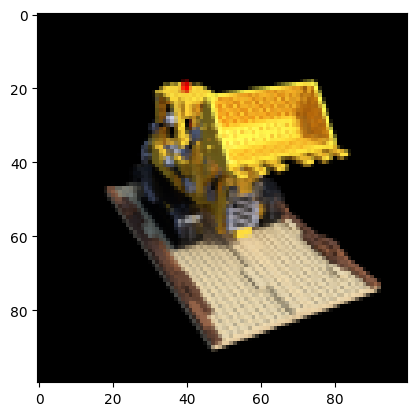

In [2]:
# Downloading the data.
from google.colab import files
uploaded = files.upload()
data_path = next(iter(uploaded))
data = np.load(data_path)
images = data["images"]
im_shape = images.shape
(num_images, H, W, _) = images.shape
(poses, focal) = (data["poses"], data["focal"])

# Plotting a random image from the dataset for visualization.
plt.imshow(images[np.random.randint(low=0, high=num_images)])
plt.show()

## Data pipeline

Let's talk about the inverse mapping, i.e. from 2D image to the 3D scene.

We'll talk about volumetric rendering with ray casting and tracing,
which are common computer graphics techniques.

Consider an image with `N` pixels. We shoot a ray through each pixel
and sample some points on the ray. A ray is commonly parameterized by
the equation `r(t) = o + td` where `t` is the parameter, `o` is the
origin and `d` is the unit directional vector as shown in **Figure 6**.

| ![img](https://i.imgur.com/ywrqlzt.gif) |
| :---: |
| **Figure 6**: `r(t) = o + td` where t is 3 |

In **Figure 7**, we consider a ray, and we sample some random points on
the ray. These sample points each have a unique location `(x, y, z)`
and the ray has a viewing angle `(theta, phi)`. The viewing angle is
particularly interesting as we can shoot a ray through a single pixel
in a lot of different ways, each with a unique viewing angle. Another
interesting thing here is the noise that is added to the
sampling process. We add a uniform noise to each sample so that the
samples correspond to a continuous distribution. In **Figure 7** the
blue points are the evenly distributed samples and the white points
`(t1, t2, t3)` are randomly placed between the samples.

| ![img](https://i.imgur.com/r9TS2wv.gif) |
| :---: |
| **Figure 7**: Sampling the points from a ray. |

**Figure 8** showcases the entire sampling process in 3D, where you
can see the rays coming out of the white image. This means that each
pixel will have its corresponding rays and each ray will be sampled at
distinct points.

| ![3-d rays](https://i.imgur.com/hr4D2g2.gif) |
| :---: |
| **Figure 8**: Shooting rays from all the pixels of an image in 3-D |

These sampled points act as the input to the NeRF model. The model is
then asked to expect the RGB color and the volume density at that
point.

| ![3-Drender](https://i.imgur.com/HHb6tlQ.png) |
| :---: |
| **Figure 9**: Data pipeline <br> |

In [3]:

def encode_position(x):
    """Encodes the position into its corresponding Fourier feature.

    Args:
        x: The input coordinate.

    Returns:
        Fourier features tensors of the position.
    """
    positions = [x]
    for i in range(POS_ENCODE_DIMS):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn(2.0**i * x))
    return tf.concat(positions, axis=-1)


def get_rays(height, width, focal, pose):
    """Computes origin point and direction vector of rays.

    Args:
        height: Height of the image.
        width: Width of the image.
        focal: The focal length between the images and the camera.
        pose: The pose matrix of the camera.

    Returns:
        Tuple of origin point and direction vector for rays.
    """
    # Building a meshgrid for the rays.
    i, j = tf.meshgrid(
        tf.range(width, dtype=tf.float32),
        tf.range(height, dtype=tf.float32),
        indexing="xy",
    )

    # Normalizing the x axis coordinates.
    transformed_i = (i - width * 0.5) / focal

    # Normalizing the y axis coordinates.
    transformed_j = (j - height * 0.5) / focal

    # Building the direction unit vectors.
    directions = tf.stack([transformed_i, -transformed_j, -tf.ones_like(i)], axis=-1)

    # Getting the camera matrix.
    camera_matrix = pose[:3, :3]
    height_width_focal = pose[:3, -1]

    # Getting origins and directions for the rays.
    transformed_dirs = directions[..., None, :]
    camera_dirs = transformed_dirs * camera_matrix
    ray_directions = tf.reduce_sum(camera_dirs, axis=-1)
    ray_origins = tf.broadcast_to(height_width_focal, tf.shape(ray_directions))

    # Returning the origins and directions.
    return (ray_origins, ray_directions)


def render_flat_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
    """Renders the rays and flattens it.

    Args:
        ray_origins: The origin points for rays.
        ray_directions: The direction unit vectors for the rays.
        near: The near bound of the volumetric scene.
        far: The far bound of the volumetric scene.
        num_samples: Number of sample points in a ray.
        rand: Choice for randomising the sampling strategy.

    Returns:
       Tuple of flattened rays and sample points on each rays.
    """
    # Computing 3D query points.
    # Equation: r(t) = o+td -> Building the "t" here.
    t_vals = tf.linspace(near, far, num_samples)
    if rand:
        # Injecting uniform noise into sample space to make the sampling
        # continuous.
        shape = list(ray_origins.shape[:-1]) + [num_samples]
        noise = tf.random.uniform(shape=shape) * (far - near) / num_samples
        t_vals = t_vals + noise

    # Equation: r(t) = o + td -> Building the "r" here.
    rays = ray_origins[..., None, :] + (
        ray_directions[..., None, :] * t_vals[..., None]
    )
    rays_flat = tf.reshape(rays, [-1, 3])
    rays_flat = encode_position(rays_flat)
    return (rays_flat, t_vals)


def map_fn(pose):
    """Maps individual pose to flattened rays and sample points.

    Args:
        pose: The pose matrix of the camera.

    Returns:
        Tuple of flattened rays and sample points corresponding to the
        camera pose.
    """
    (ray_origins, ray_directions) = get_rays(height=H, width=W, focal=focal, pose=pose)
    (rays_flat, t_vals) = render_flat_rays(
        ray_origins=ray_origins,
        ray_directions=ray_directions,
        near=2.0,
        far=6.0,
        num_samples=NUM_SAMPLES,
        rand=True,
    )
    return (rays_flat, t_vals)


# Building the training split.
split_index = int(num_images * 0.8)

# Splitting images into training and validation.
train_images = images[:split_index]
val_images = images[split_index:]

# Splitting poses into training and validation.
train_poses = poses[:split_index]
val_poses = poses[split_index:]

# Making the training pipeline.
train_img_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses)
train_ray_ds = train_pose_ds.map(map_fn, num_parallel_calls=AUTO)
training_ds = tf.data.Dataset.zip((train_img_ds, train_ray_ds))
train_ds = (
    training_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# Making the validation pipeline.
val_img_ds = tf.data.Dataset.from_tensor_slices(val_images)
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses)
val_ray_ds = val_pose_ds.map(map_fn, num_parallel_calls=AUTO)
validation_ds = tf.data.Dataset.zip((val_img_ds, val_ray_ds))
val_ds = (
    validation_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

## NeRF model

The model has ReLU as its non-linearity.


Our representation is multiview-consistent by
restricting the network to expect the volume density sigma as a
function of only the location `x`, while allowing the RGB color `c` to be
expected as a function of both location and viewing direction. To
accomplish this, the model first processes the input 3D coordinate `x`
with 8 fully-connected layers (using ReLU activations and 256 channels
per layer), and outputs sigma and a 256-dimensional feature vector.
This feature vector is then concatenated with the camera ray's viewing
direction and passed to one additional fully-connected layer (using a
ReLU activation and 128 channels) that output the view-dependent RGB
color.

Here we have used 64
Dense units instead of 256.

In [4]:

def get_nerf_model(num_layers, num_pos):
    """Generates the NeRF network.

    Args:
        num_layers: Number of layers.
        num_pos: Number of dimensions of positional encoding.

    Returns:
        The `keras` model.
    """
    inputs = keras.Input(shape=(num_pos, 2 * 3 * POS_ENCODE_DIMS + 3))
    x = inputs
    for i in range(num_layers):
        x = layers.Dense(units=64, activation="relu")(x)
        if i % 4 == 0 and i > 0:
            # Injecting residual connection.
            x = layers.concatenate([x, inputs], axis=-1)
    outputs = layers.Dense(units=4)(x)
    return keras.Model(inputs=inputs, outputs=outputs)


def render_rgb_depth(model, rays_flat, t_vals, rand=True, train=True):
    """Generates the RGB image and depth map from model expectation.

    Args:
        model: The model that is trained to expect the rgb and
            volume density of the volumetric scene.
        rays_flat: The flattened rays that serve as the input to
            the NeRF model.
        t_vals: The sample points for the rays.
        rand: Choice to randomise the sampling strategy.
        train: Whether the model is in the training or testing phase.

    Returns:
        Tuple of rgb image and depth map.
    """
    # Getting the expectation from the nerf model and reshaping it.
           # It was said:
    if train:
        predictions = model(rays_flat)
    else:
        predictions = model.predict(rays_flat)
    predictions = tf.reshape(predictions, shape=(BATCH_SIZE, H, W, NUM_SAMPLES, 4))

    # Slicing the expectations into rgb and sigma.
    rgb = tf.sigmoid(predictions[..., :-1])
    sigma_a = tf.nn.relu(predictions[..., -1])
           # was said.

    # Getting the distance of adjacent intervals.
    delta = t_vals[..., 1:] - t_vals[..., :-1]
    # delta shape = (num_samples)
    if rand:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, H, W, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta)
    else:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta[:, None, None, :])

    # Getting transmittance.
    exp_term = 1.0 - alpha
    epsilon = 1e-10
    transmittance = tf.math.cumprod(exp_term + epsilon, axis=-1, exclusive=True)
    weights = alpha * transmittance
    rgb = tf.reduce_sum(weights[..., None] * rgb, axis=-2)

    if rand:
        depth_map = tf.reduce_sum(weights * t_vals, axis=-1)
    else:
        depth_map = tf.reduce_sum(weights * t_vals[:, None, None], axis=-1)
    return (rgb, depth_map)


## Training

The training step is implemented as part of a custom `keras.Model` subclass
so that we can make use of the `model.fit` functionality.

Epoch 1/20
1/1 [==============================] - 7s 7s/step


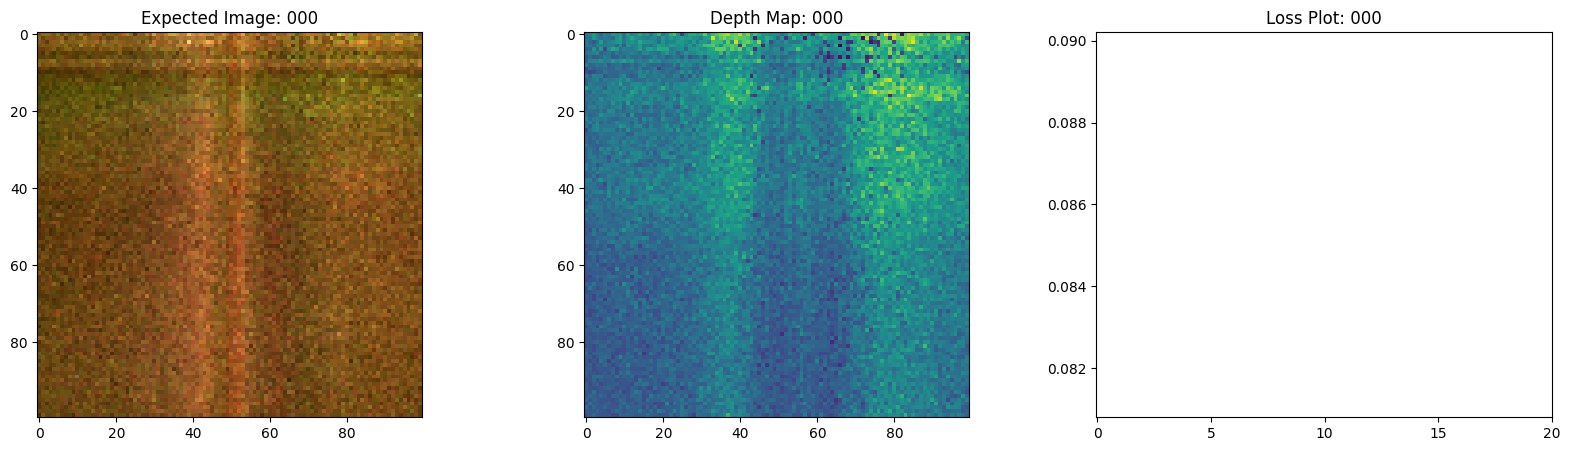

16/16 [==============================] - 348s 21s/step - loss: 0.0855 - psnr: 11.0584 - val_loss: 0.0741 - val_psnr: 11.8194
Epoch 2/20
1/1 [==============================] - 6s 6s/step


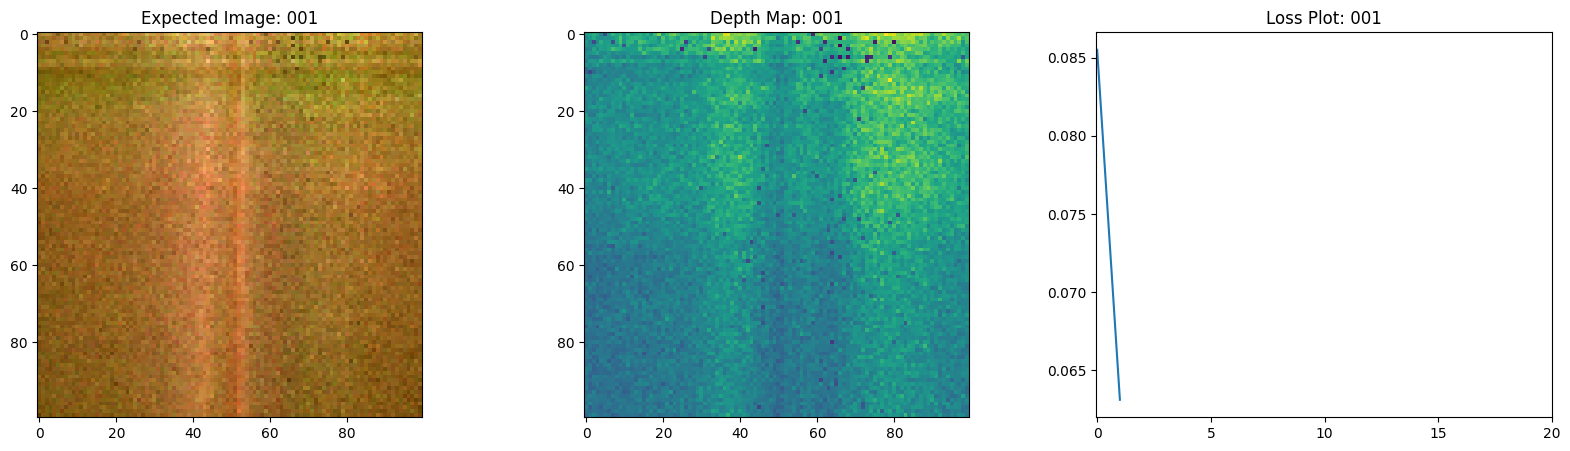

16/16 [==============================] - 343s 21s/step - loss: 0.0631 - psnr: 12.4346 - val_loss: 0.0652 - val_psnr: 12.1869
Epoch 3/20
1/1 [==============================] - 6s 6s/step


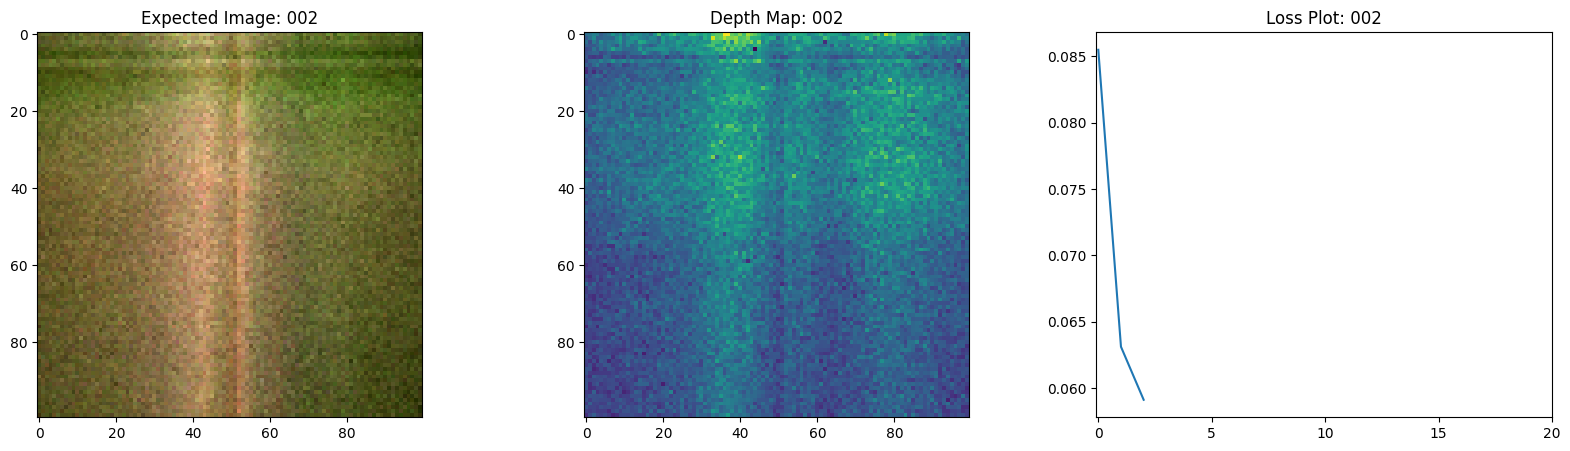

16/16 [==============================] - 340s 21s/step - loss: 0.0591 - psnr: 12.6817 - val_loss: 0.0656 - val_psnr: 12.1386
Epoch 4/20
1/1 [==============================] - 6s 6s/step


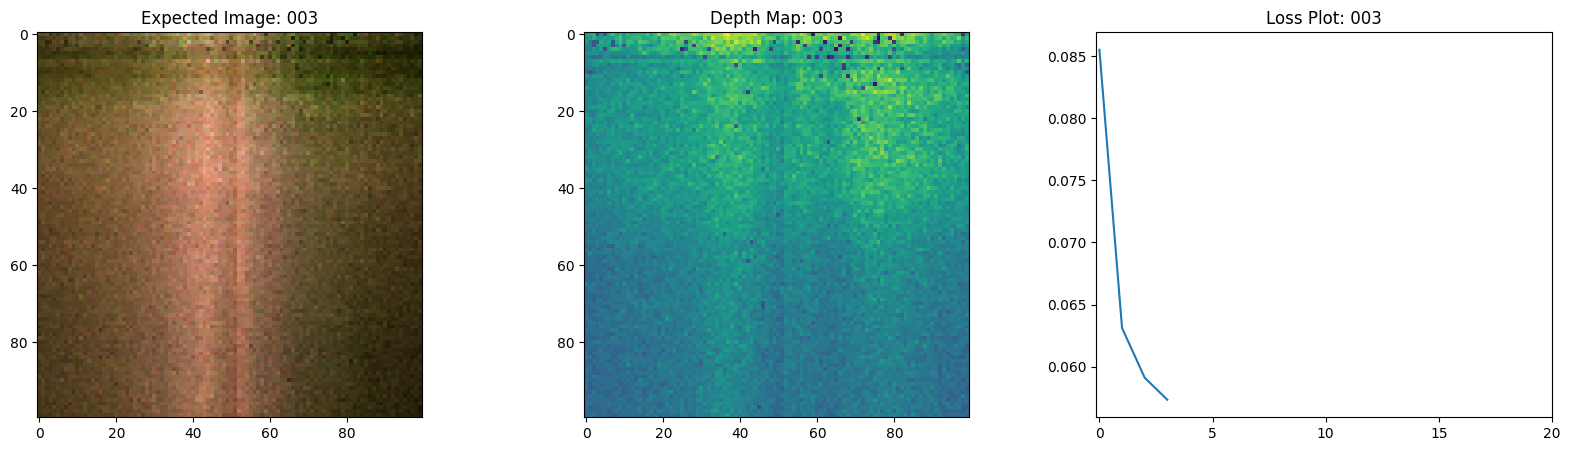

16/16 [==============================] - 343s 21s/step - loss: 0.0573 - psnr: 12.8463 - val_loss: 0.0609 - val_psnr: 12.5245
Epoch 5/20
1/1 [==============================] - 7s 7s/step


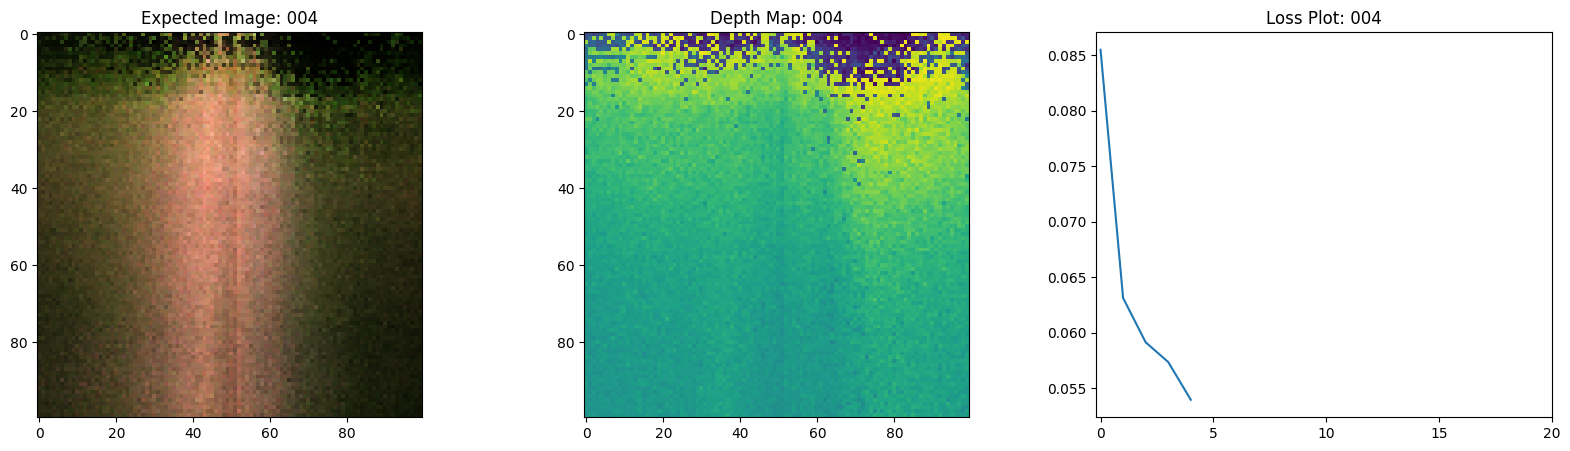

16/16 [==============================] - 330s 20s/step - loss: 0.0539 - psnr: 13.1007 - val_loss: 0.0530 - val_psnr: 13.1532
Epoch 6/20
1/1 [==============================] - 7s 7s/step


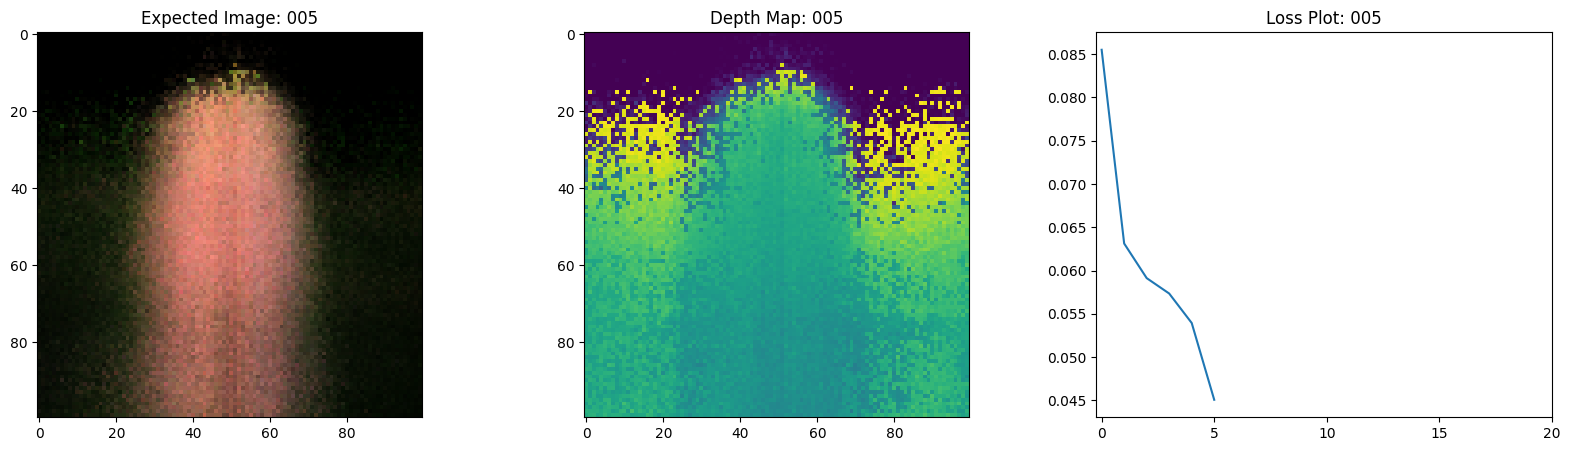

16/16 [==============================] - 331s 20s/step - loss: 0.0451 - psnr: 13.9168 - val_loss: 0.0416 - val_psnr: 14.1577
Epoch 7/20
1/1 [==============================] - 7s 7s/step


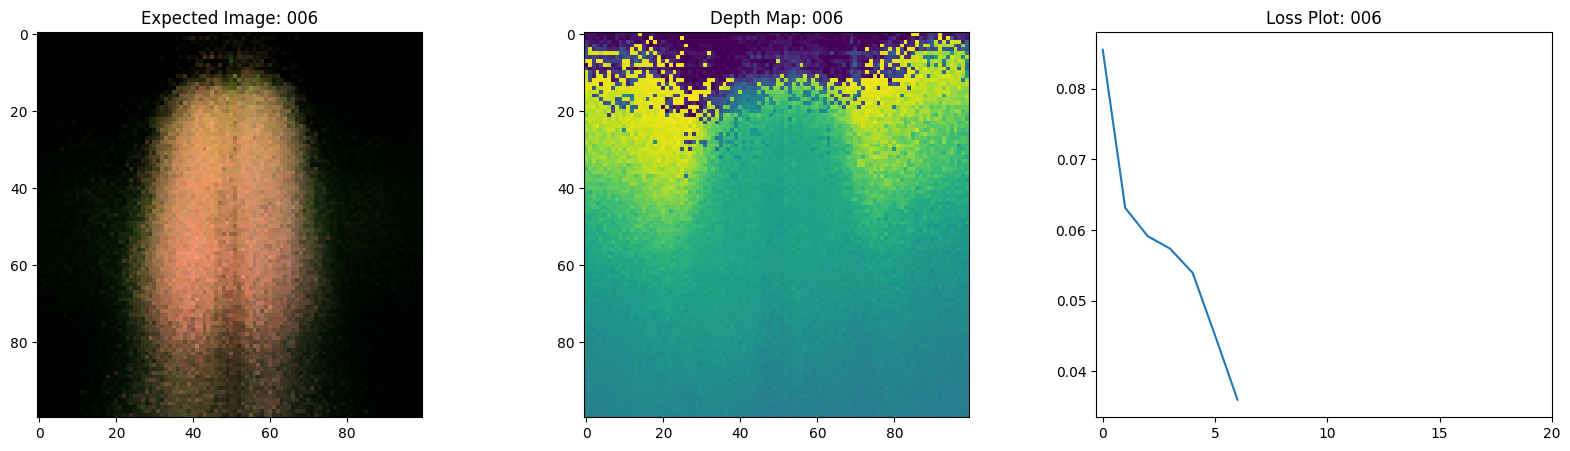

16/16 [==============================] - 343s 21s/step - loss: 0.0360 - psnr: 14.8572 - val_loss: 0.0345 - val_psnr: 14.7957
Epoch 8/20
1/1 [==============================] - 6s 6s/step


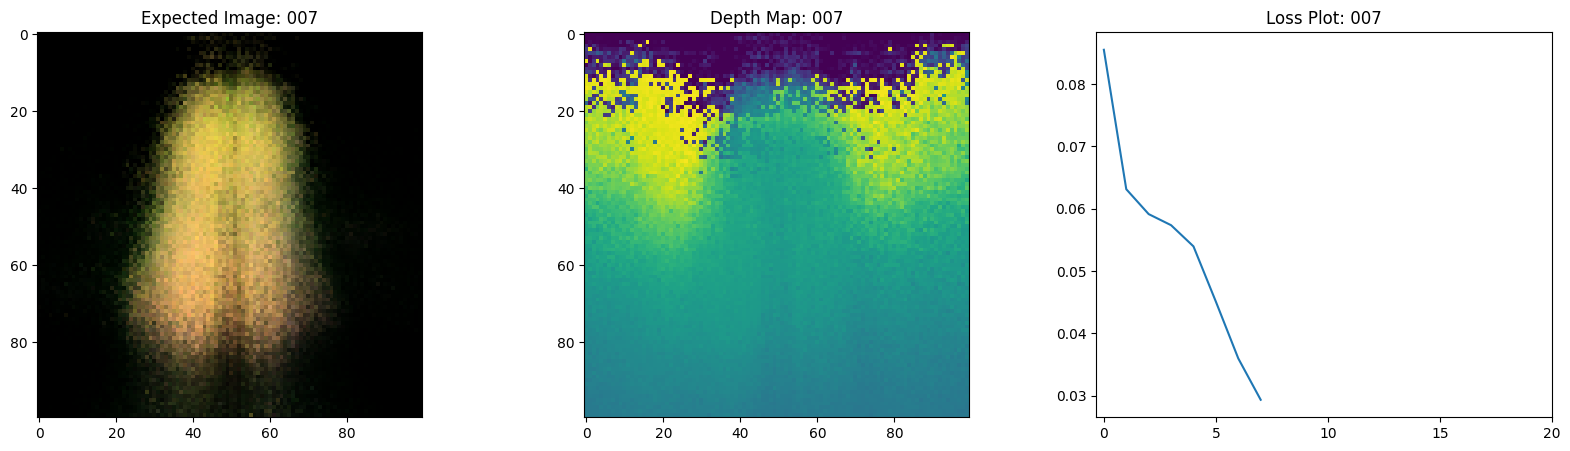

16/16 [==============================] - 336s 21s/step - loss: 0.0293 - psnr: 15.6258 - val_loss: 0.0280 - val_psnr: 15.6945
Epoch 9/20
1/1 [==============================] - 7s 7s/step


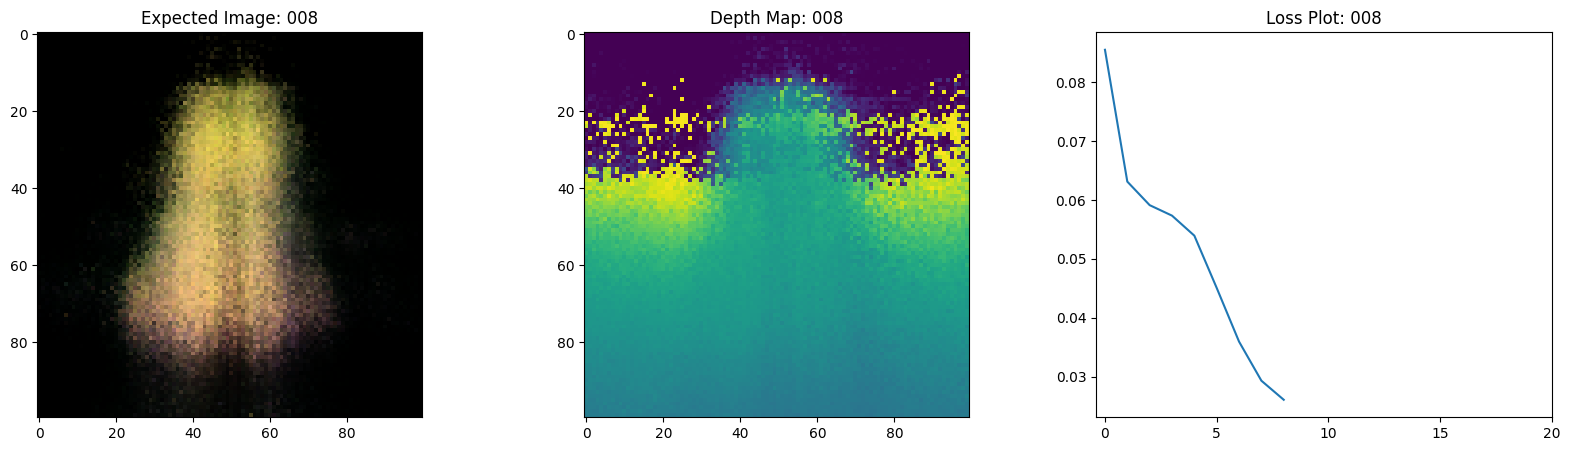

16/16 [==============================] - 340s 21s/step - loss: 0.0261 - psnr: 16.0668 - val_loss: 0.0242 - val_psnr: 16.3075
Epoch 10/20
1/1 [==============================] - 7s 7s/step


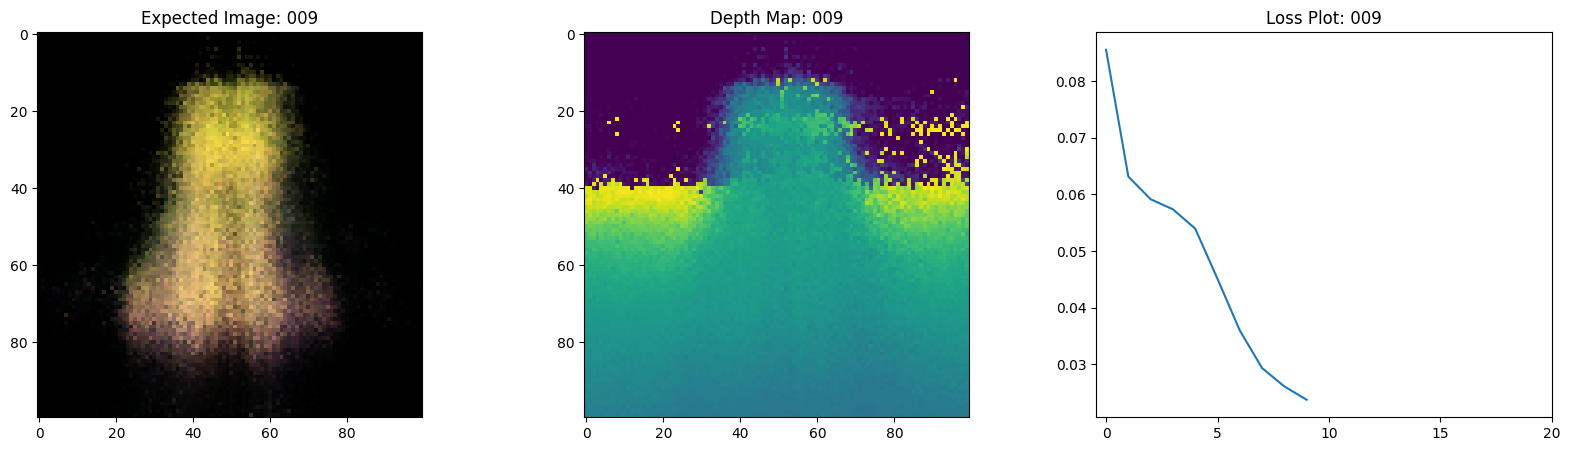

16/16 [==============================] - 340s 21s/step - loss: 0.0237 - psnr: 16.4590 - val_loss: 0.0223 - val_psnr: 16.6121
Epoch 11/20
1/1 [==============================] - 7s 7s/step


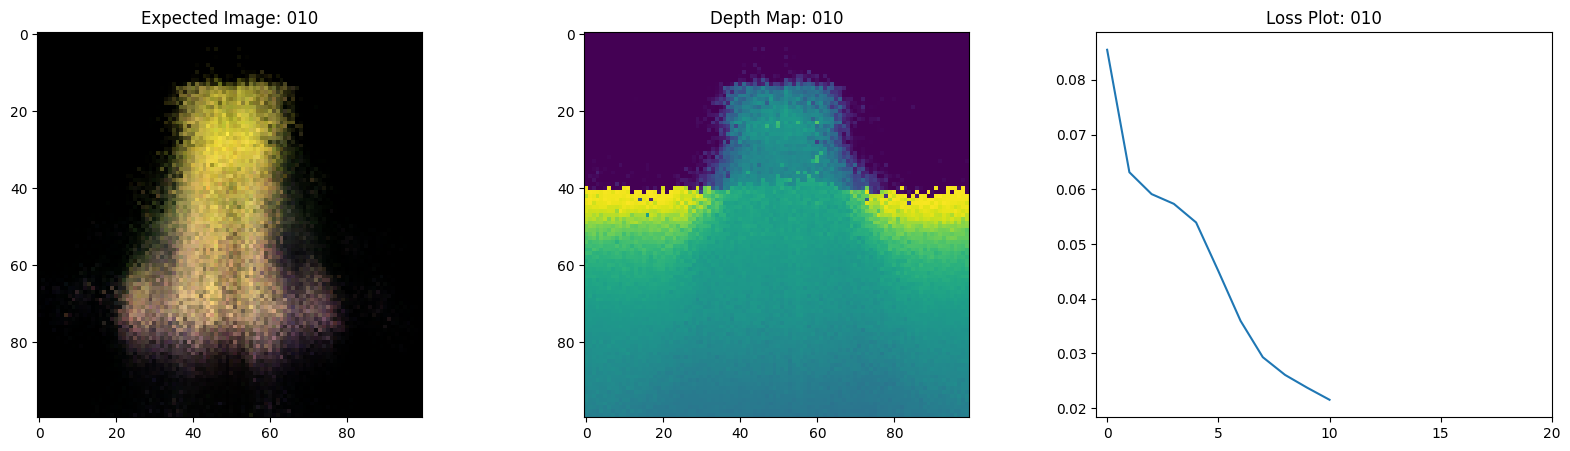

16/16 [==============================] - 330s 20s/step - loss: 0.0215 - psnr: 16.8391 - val_loss: 0.0198 - val_psnr: 17.1415
Epoch 12/20
1/1 [==============================] - 7s 7s/step


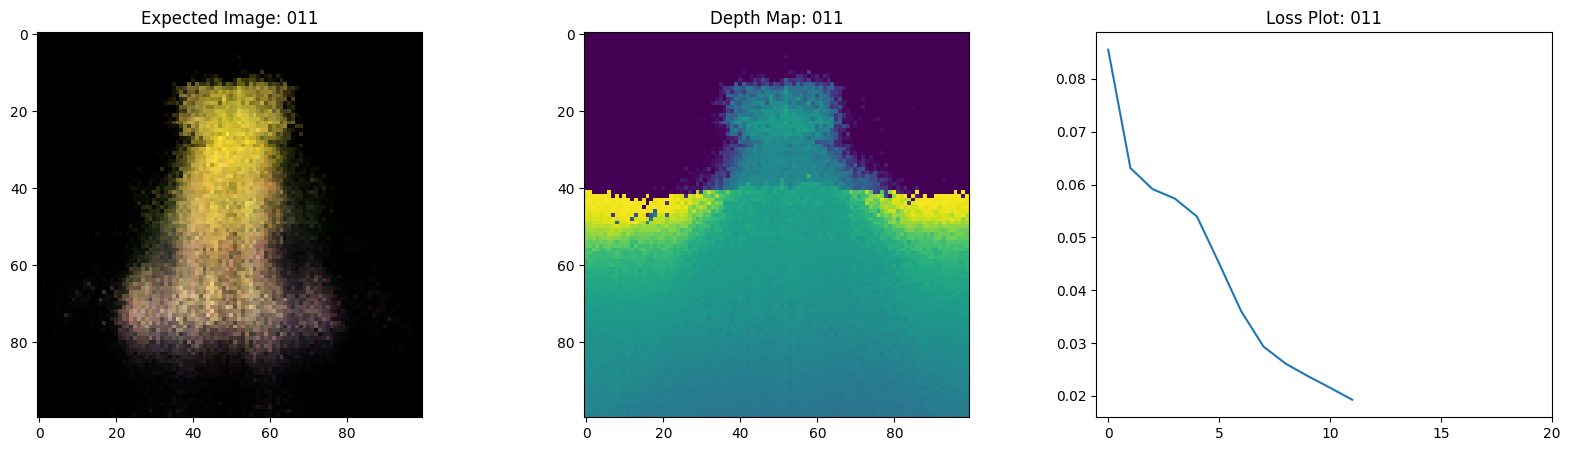

16/16 [==============================] - 346s 21s/step - loss: 0.0193 - psnr: 17.3123 - val_loss: 0.0178 - val_psnr: 17.5947
Epoch 13/20
1/1 [==============================] - 6s 6s/step


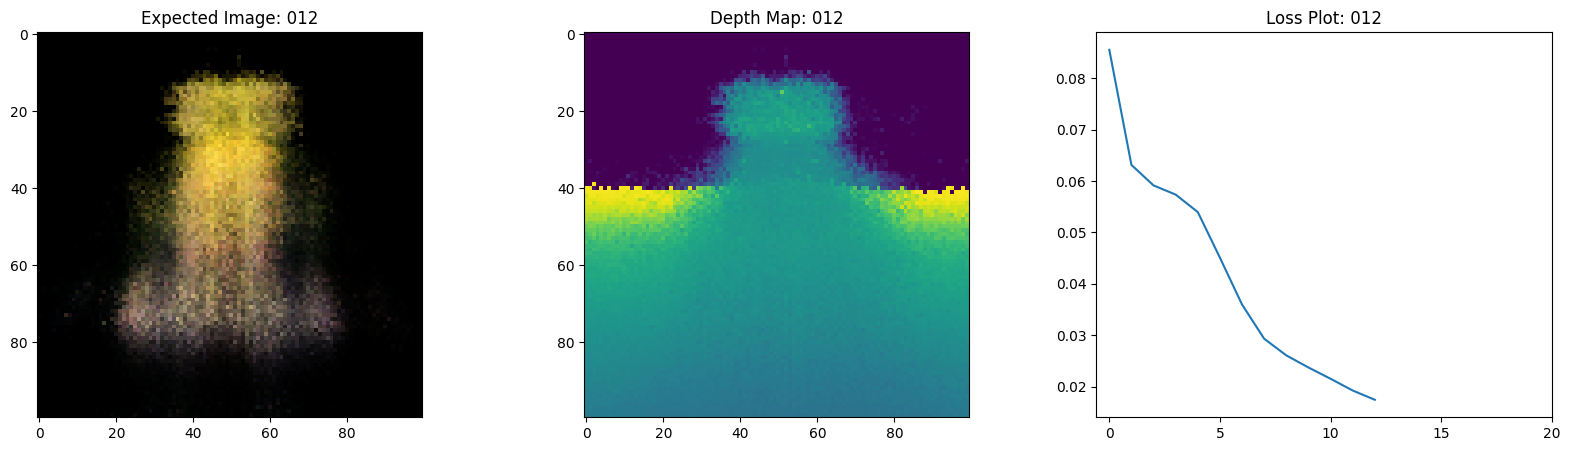

16/16 [==============================] - 345s 21s/step - loss: 0.0175 - psnr: 17.7109 - val_loss: 0.0178 - val_psnr: 17.5737
Epoch 14/20
1/1 [==============================] - 6s 6s/step


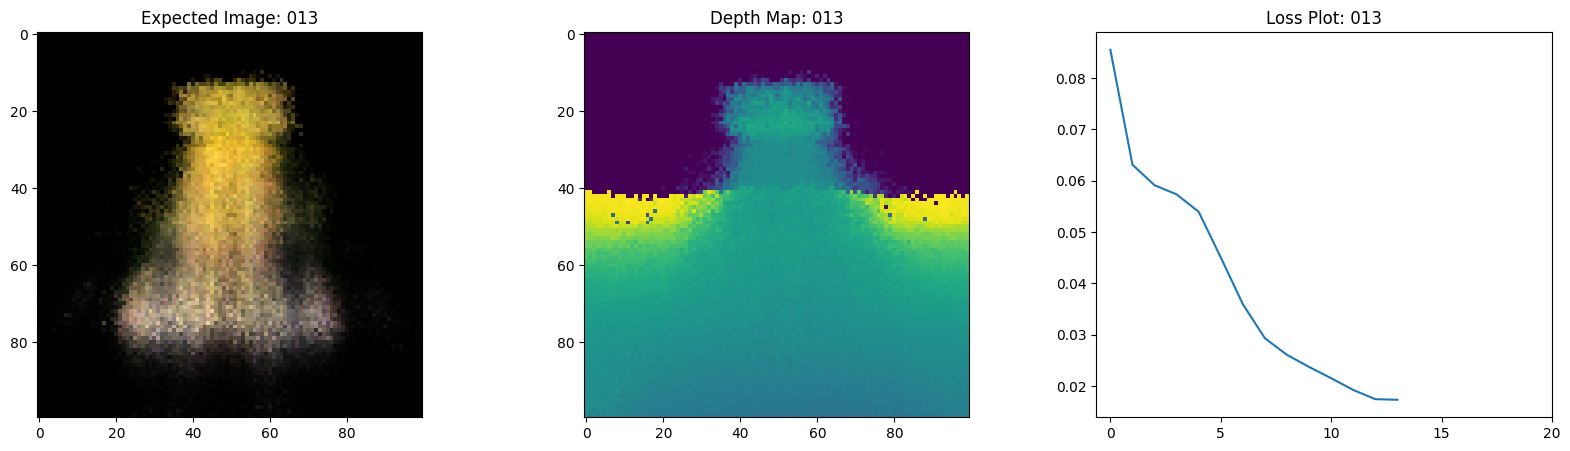

16/16 [==============================] - 345s 21s/step - loss: 0.0173 - psnr: 17.7685 - val_loss: 0.0159 - val_psnr: 18.0315
Epoch 15/20
1/1 [==============================] - 7s 7s/step


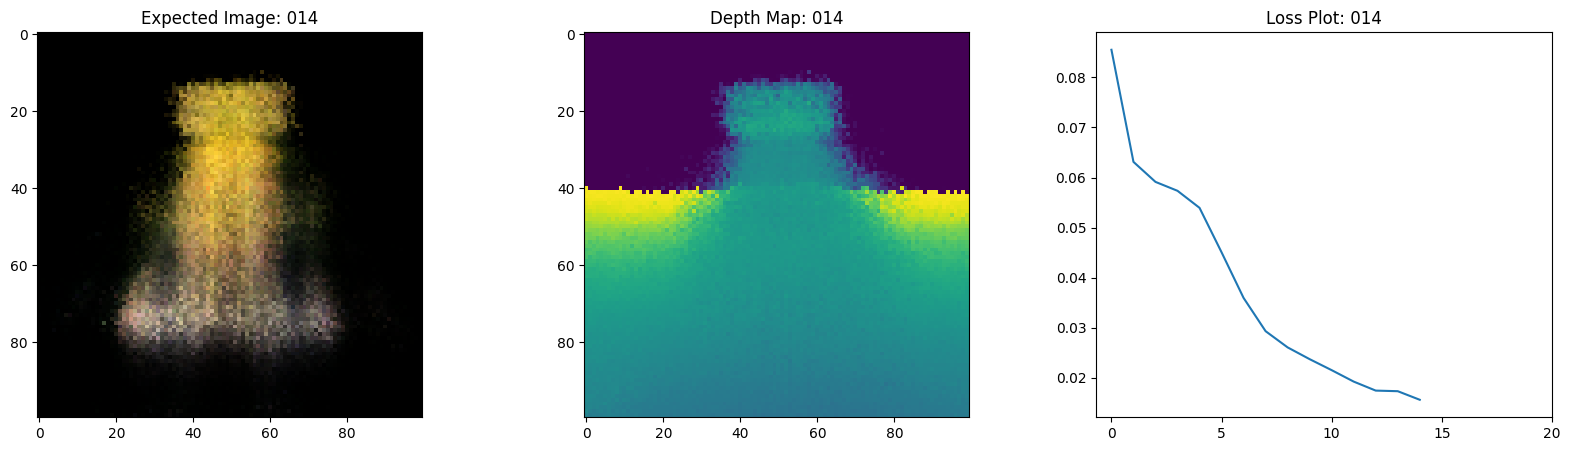

16/16 [==============================] - 346s 21s/step - loss: 0.0156 - psnr: 18.2143 - val_loss: 0.0146 - val_psnr: 18.4283
Epoch 16/20
1/1 [==============================] - 7s 7s/step


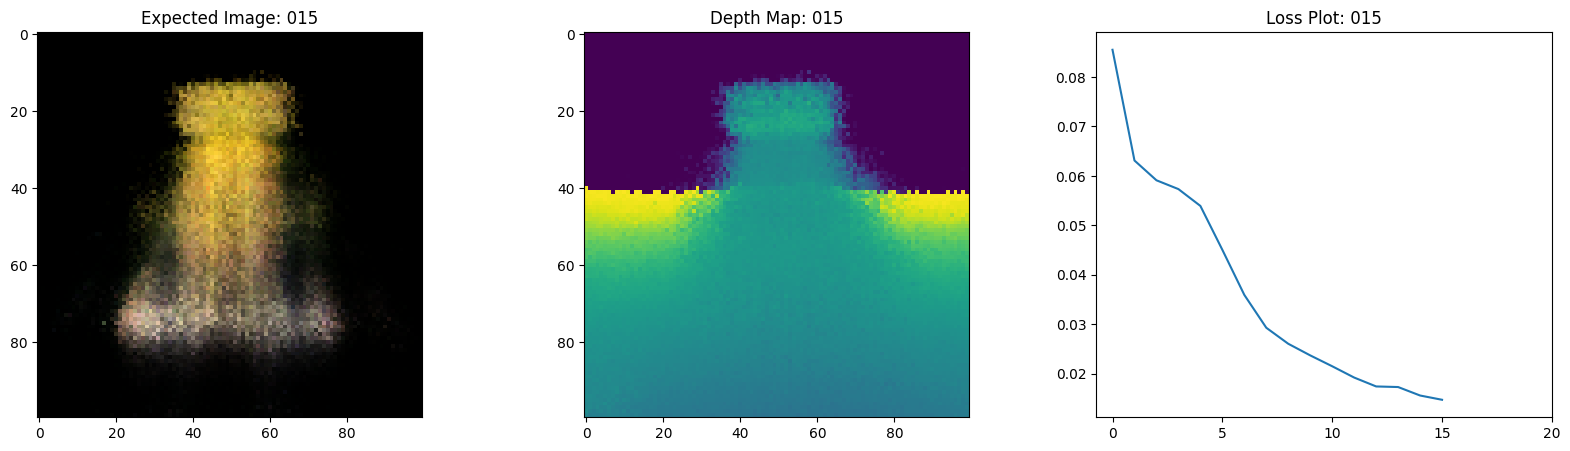

16/16 [==============================] - 345s 21s/step - loss: 0.0148 - psnr: 18.4439 - val_loss: 0.0143 - val_psnr: 18.5160
Epoch 17/20
1/1 [==============================] - 7s 7s/step


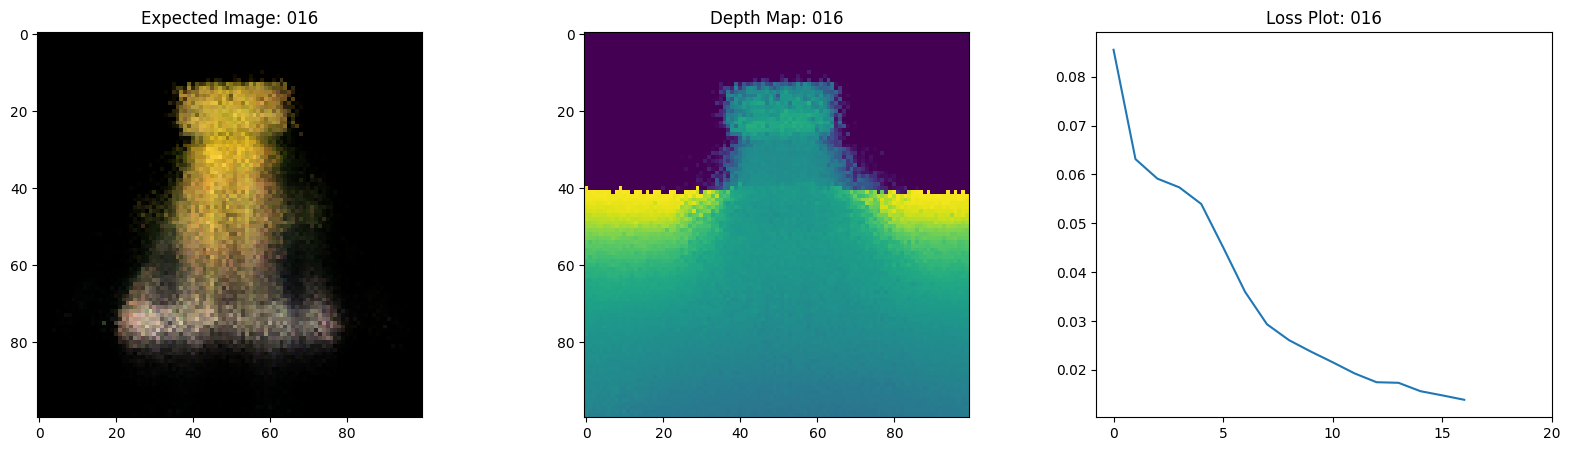

16/16 [==============================] - 332s 20s/step - loss: 0.0139 - psnr: 18.7232 - val_loss: 0.0138 - val_psnr: 18.7101
Epoch 18/20
1/1 [==============================] - 7s 7s/step


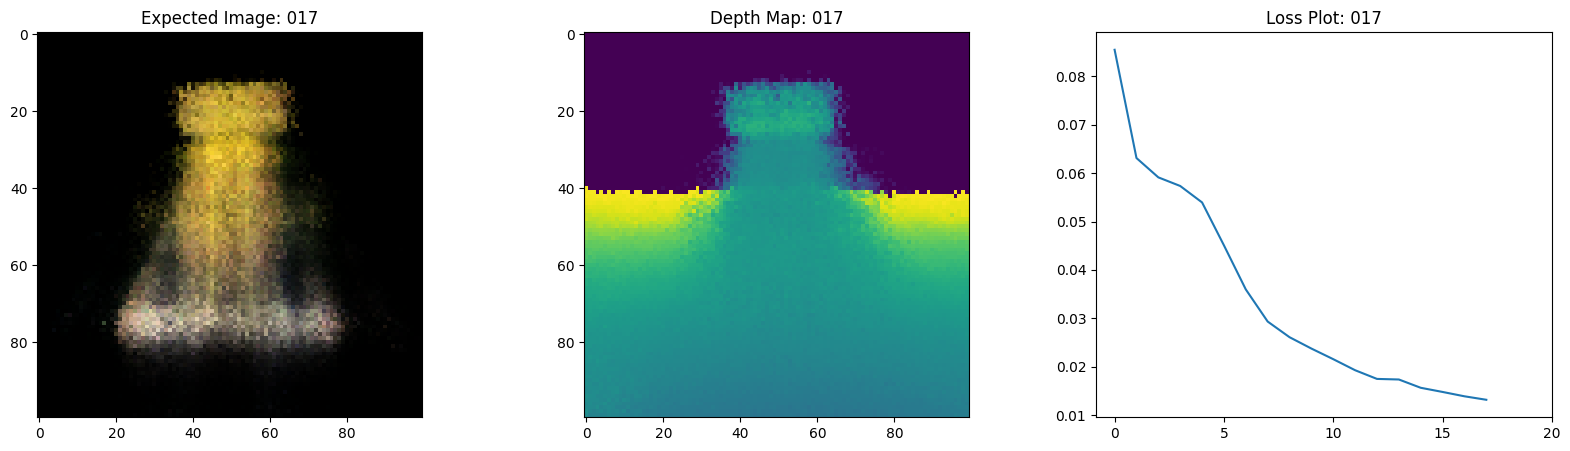

16/16 [==============================] - 346s 21s/step - loss: 0.0131 - psnr: 18.9434 - val_loss: 0.0137 - val_psnr: 18.7041
Epoch 19/20
1/1 [==============================] - 6s 6s/step


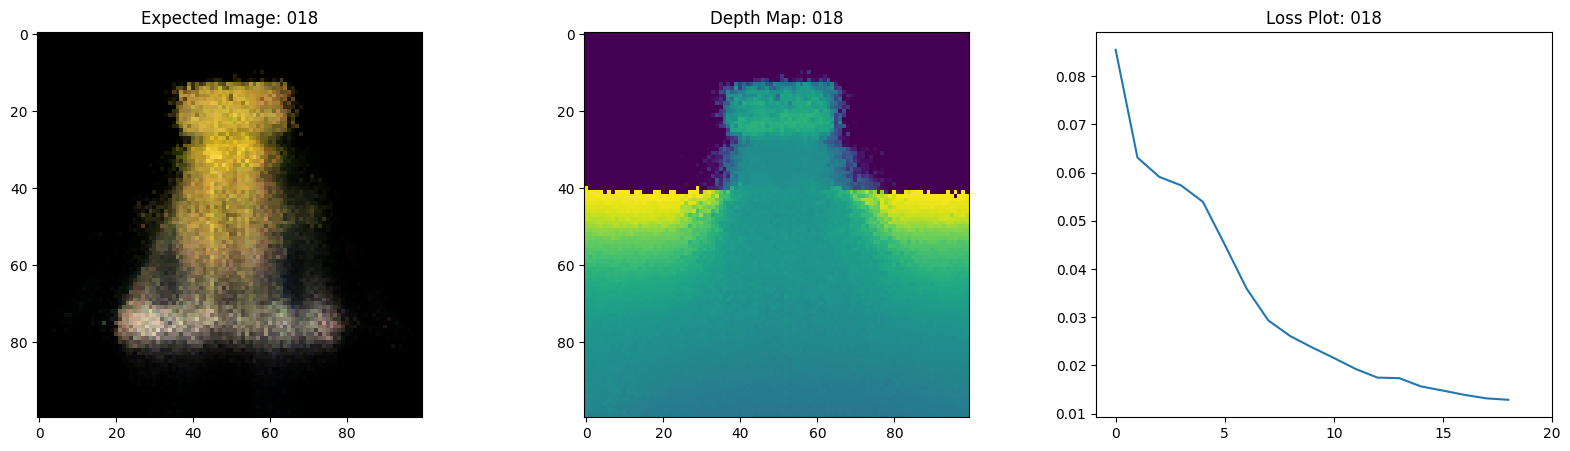

16/16 [==============================] - 344s 21s/step - loss: 0.0129 - psnr: 19.0470 - val_loss: 0.0127 - val_psnr: 19.0170
Epoch 20/20
1/1 [==============================] - 6s 6s/step


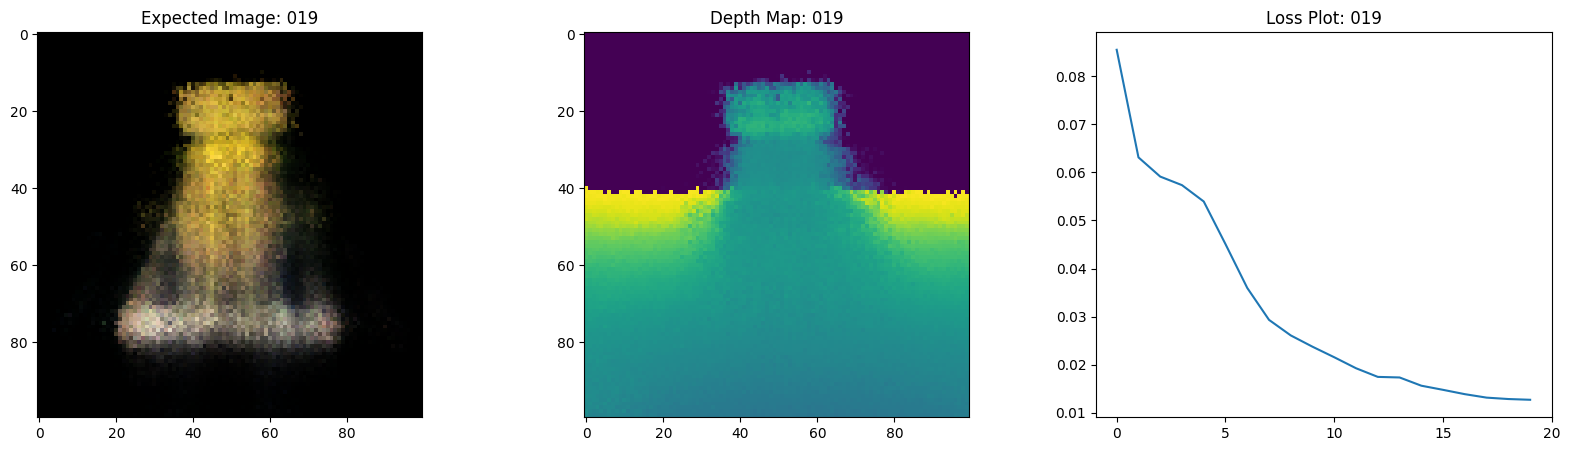

16/16 [==============================] - 344s 21s/step - loss: 0.0127 - psnr: 19.1001 - val_loss: 0.0125 - val_psnr: 19.1122


100%|██████████| 20/20 [00:00<00:00, 38.50it/s]


In [5]:

class NeRF(keras.Model):
    def __init__(self, nerf_model):
        super().__init__()
        self.nerf_model = nerf_model

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_metric = keras.metrics.Mean(name="psnr")

    def train_step(self, inputs):
        # Getting  images and rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        with tf.GradientTape() as tape:
            # Getting expectation from model.
            rgb, _ = render_rgb_depth(
                model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
            )
            loss = self.loss_fn(images, rgb)

        # Getting trainable variables.
        trainable_variables = self.nerf_model.trainable_variables

        # Getting gradients of trainiable variables with consideration to the loss.
        gradients = tape.gradient(loss, trainable_variables)

        # Applying grads and optimizing the model.
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        # Getting the PSNR of reconstructed images and source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Computing metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    def test_step(self, inputs):
        # Getting images and rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        # Getting expectations from the model.
        rgb, _ = render_rgb_depth(
            model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
        )
        loss = self.loss_fn(images, rgb)

        # Getting the PSNR of reconstructed images and source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Computing metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_metric]


test_imgs, test_rays = next(iter(train_ds))
test_rays_flat, test_t_vals = test_rays

loss_list = []


class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)
        test_recons_images, depth_maps = render_rgb_depth(
            model=self.model.nerf_model,
            rays_flat=test_rays_flat,
            t_vals=test_t_vals,
            rand=True,
            train=False,
        )

        # Plotting rgb, depth and loss plot.
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(keras.utils.array_to_img(test_recons_images[0]))
        ax[0].set_title(f"Expected Image: {epoch:03d}")

        ax[1].imshow(keras.utils.array_to_img(depth_maps[0, ..., None]))
        ax[1].set_title(f"Depth Map: {epoch:03d}")

        ax[2].plot(loss_list)
        ax[2].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
        ax[2].set_title(f"Loss Plot: {epoch:03d}")

        fig.savefig(f"images/{epoch:03d}.png")
        plt.show()
        plt.close()


num_pos = H * W * NUM_SAMPLES
nerf_model = get_nerf_model(num_layers=8, num_pos=num_pos)

model = NeRF(nerf_model)
model.compile(
              # It was said:
    optimizer=keras.optimizers.Adam(), loss_fn=keras.losses.MeanSquaredError()
              # was said.
)

# Building a directory to save images during training.
if not os.path.exists("images"):
    os.makedirs("images")

model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[TrainMonitor()],
)


              # It was said:
def create_gif(path_to_images, name_gif):
    filenames = glob.glob(path_to_images)
    filenames = sorted(filenames)
    images = []
    for filename in tqdm(filenames):
        images.append(imageio.imread(filename))
    kargs = {"duration": 0.25}
    imageio.mimsave(name_gif, images, "GIF", **kargs)


create_gif("images/*.png", "training.gif")
              # was said.

## Visualizing training step

Here we see training step. With the decreasing loss, the rendered
image and the depth maps are getting better. In your local system, you
will see the `training.gif` file generated.

It was said:
![training-20](https://i.imgur.com/ql5OcYA.gif)
was said.











## Inference

In this section, we ask the model to build novel views of the scene.
The model was given `106` views of the scene in the training step. The
collections of training images cannot contain each and every angle of
the scene. A trained model can represent the entire 3-D scene with a
sparse set of training images.

Here we provide different poses to the model and ask for it to give us
the 2-D image corresponding to that camera view. If we infer the model
for all the 360-degree views, it provide an overview of the
entire scenery from all around.

1/1 [==============================] - 6s 6s/step


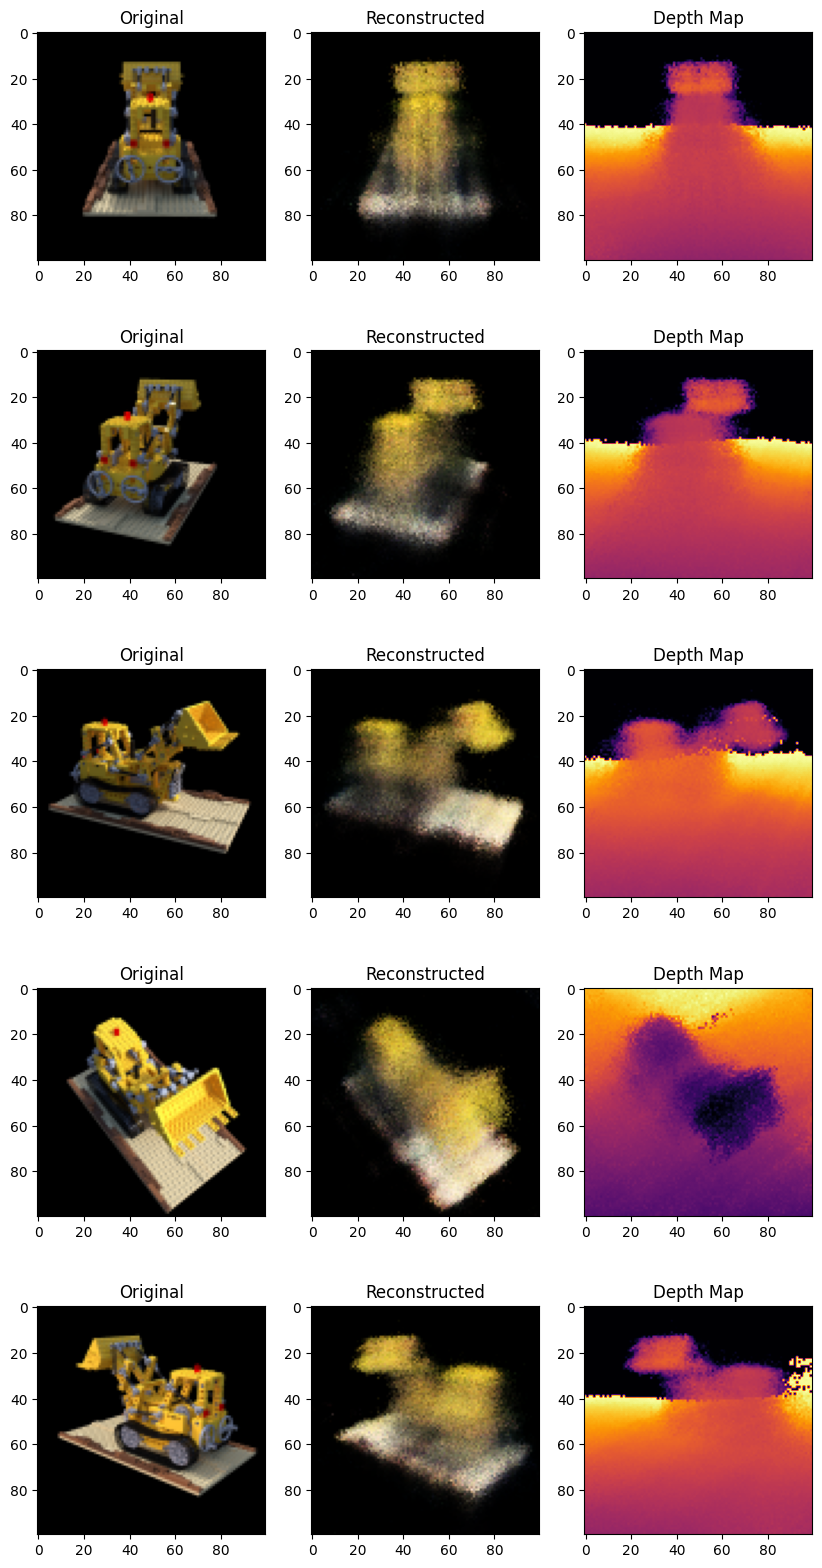

In [6]:
# Getting trained NeRF model and infer.
nerf_model = model.nerf_model
test_recons_images, depth_maps = render_rgb_depth(
    model=nerf_model,
    rays_flat=test_rays_flat,
    t_vals=test_t_vals,
    rand=True,
    train=False,
)

# Making subplots.
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))

for ax, ori_img, recons_img, depth_map in zip(
    axes, test_imgs, test_recons_images, depth_maps
):
    ax[0].imshow(keras.utils.array_to_img(ori_img))
    ax[0].set_title("Original")

    ax[1].imshow(keras.utils.array_to_img(recons_img))
    ax[1].set_title("Reconstructed")

        # It was said:
    ax[2].imshow(keras.utils.array_to_img(depth_map[..., None]), cmap="inferno")
    ax[2].set_title("Depth Map")
        # was said.

## Rendering 3D Scene

Here we will synthesize novel 3D views and stitch all of them together
to render a video encompassing the 360-degree view.

In [7]:

def get_translation_t(t):
    """Getting translation matrix for movement in t."""
    matrix = [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_phi(phi):
    """Getting rotation matrix for movement in phi."""
    matrix = [
        [1, 0, 0, 0],
        [0, tf.cos(phi), -tf.sin(phi), 0],
        [0, tf.sin(phi), tf.cos(phi), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_theta(theta):
    """Getting rotation matrix for movement in theta."""
    matrix = [
        [tf.cos(theta), 0, -tf.sin(theta), 0],
        [0, 1, 0, 0],
        [tf.sin(theta), 0, tf.cos(theta), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def pose_spherical(theta, phi, t):
    """
    Getting camera to 3D matrix for the corresponding theta, phi
    and t.
    """
    c2w = get_translation_t(t)
    c2w = get_rotation_phi(phi / 180.0 * np.pi) @ c2w
    c2w = get_rotation_theta(theta / 180.0 * np.pi) @ c2w
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w


rgb_frames = []
batch_flat = []
batch_t = []

# Iterating over different theta value and generating scenes.
for index, theta in tqdm(enumerate(np.linspace(0.0, 360.0, 120, endpoint=False))):
    # Getting camera to 3D matrix.
    c2w = pose_spherical(theta, -30.0, 4.0)


    ray_oris, ray_dirs = get_rays(H, W, focal, c2w)
    rays_flat, t_vals = render_flat_rays(
        ray_oris, ray_dirs, near=2.0, far=6.0, num_samples=NUM_SAMPLES, rand=False
    )

    if index % BATCH_SIZE == 0 and index > 0:
        batched_flat = tf.stack(batch_flat, axis=0)
        batch_flat = [rays_flat]

        batched_t = tf.stack(batch_t, axis=0)
        batch_t = [t_vals]

        rgb, _ = render_rgb_depth(
            nerf_model, batched_flat, batched_t, rand=False, train=False
        )

        temp_rgb = [np.clip(255 * img, 0.0, 255.0).astype(np.uint8) for img in rgb]

        rgb_frames = rgb_frames + temp_rgb
    else:
        batch_flat.append(rays_flat)
        batch_t.append(t_vals)

rgb_video = "rgb_video.mp4"
imageio.mimwrite(rgb_video, rgb_frames, fps=30, quality=7, macro_block_size=None)

5it [00:01,  3.45it/s]

1/1 [==============================] - 6s 6s/step


10it [00:13,  1.08s/it]

1/1 [==============================] - 6s 6s/step


15it [00:22,  1.01it/s]

1/1 [==============================] - 6s 6s/step


20it [00:35,  1.31s/it]

1/1 [==============================] - 6s 6s/step


25it [00:42,  1.13it/s]

1/1 [==============================] - 7s 7s/step


30it [00:54,  1.15s/it]

1/1 [==============================] - 7s 7s/step


35it [01:06,  1.19s/it]

1/1 [==============================] - 7s 7s/step


40it [01:15,  1.04it/s]

1/1 [==============================] - 7s 7s/step


45it [01:27,  1.15s/it]

1/1 [==============================] - 6s 6s/step


50it [01:35,  1.14it/s]

1/1 [==============================] - 7s 7s/step


55it [01:45,  1.06s/it]

1/1 [==============================] - 7s 7s/step


60it [01:57,  1.20s/it]

1/1 [==============================] - 7s 7s/step


65it [02:06,  1.03it/s]

1/1 [==============================] - 6s 6s/step


70it [02:18,  1.16s/it]

1/1 [==============================] - 6s 6s/step


75it [02:30,  1.19s/it]

1/1 [==============================] - 6s 6s/step


80it [02:38,  1.14it/s]

1/1 [==============================] - 7s 7s/step


85it [02:50,  1.16s/it]

1/1 [==============================] - 7s 7s/step


90it [02:59,  1.02it/s]

1/1 [==============================] - 6s 6s/step


95it [03:11,  1.16s/it]

1/1 [==============================] - 6s 6s/step


100it [03:24,  1.22s/it]

1/1 [==============================] - 6s 6s/step


105it [03:36,  1.19s/it]

1/1 [==============================] - 6s 6s/step


110it [03:48,  1.21s/it]

1/1 [==============================] - 6s 6s/step


115it [03:57,  1.04s/it]

1/1 [==============================] - 6s 6s/step


120it [04:04,  2.04s/it]
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


### Visualizing video

Here we can see the rendered 360 degree view of the scene. The model
has learned the entire volumetric space of an object through the
sparse set of images in **only 20 epochs**. The
rendered video saved locally can be viewed, named `rgb_video.mp4`.

In [9]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('rgb_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Conclusion

We have produced a 3D volumetric rendering.

Below we
have also provided the outputs of the model trained for more epochs.
It was said:

| Epochs | GIF of the training step |
| :--- | :---: |
| **100** | ![100-epoch-training](https://i.imgur.com/2k9p8ez.gif) |
was said.
It was said:
| **200** | ![200-epoch-training](https://i.imgur.com/l3rG4HQ.gif) |
was said.